# Title  
## Enhancing a Bollinger Bands Trading Strategy Using Machine Learning and Cross-Validation

# Abstract  

This project investigates whether machine learning (ML) models can improve the performance of a traditional Bollinger Bands trading strategy for U.S. equity markets. Using daily price data for Apple Inc. (AAPL) from the course dataset `AAPL Yahoo.csv` (sample period: 2010-12-31 to 2013-12-31), I construct several technical indicators including Bollinger Bands, moving averages, RSI, and daily returns to capture short-term market dynamics.

I frame the problem as a binary classification task that predicts whether the next-day return will be positive. Two ML models are considered: K-Nearest Neighbors (KNN) and L2-regularized Logistic Regression. Both models are trained and tuned using K-fold cross-validation to reduce overfitting and improve robustness. I then compare three trading approaches over the test period (2013-06-03 to 2013-12-30): <br>
(i) buy-and-hold <br>
(ii) a simple Bollinger Bands rule <br>
(iii) ML based strategies that take long or cash positions based on model predictions.

Empirically, KNN performs poorly out of sample, with a test accuracy of about 44%. Logistic Regression performs better, achieving a test accuracy of about 54%, which is modestly above a 50% random baseline and typical for daily return prediction. In terms of trading performance, buy and hold delivers the highest total return (34.71%), but the Logistic Regression strategy (21.11%) clearly outperforms both the KNN strategy (6.83%) and the Bollinger Bands strategy (-8.39%). These results illustrate how classification, resampling methods, and regularization can be integrated with technical analysis to evaluate and improve data-driven trading strategies, while also highlighting the difficulty of beating a simple buy and hold benchmark over this sample.

# Introduction

Technical analysis is widely used by practitioners to identify trading opportunities based on historical price patterns. Among many indicators, Bollinger Bands are popular for detecting potential overbought and oversold conditions. However, fixed-rule strategies based solely on such indicators may fail to adapt to changing market regimes and can produce noisy signals.

In this project, I explore whether machine learning (ML) models can extract more information from technical indicators and improve trading decisions compared with a simple Bollinger Bands strategy. The central research question is:

##### <font color='green'> **Can classification models trained on technical indicators outperform a basic Bollinger Bands rule in predicting next-day price direction and generating trading returns?**

To address this question, I use AAPL daily price data from 2010-12-31 to 2013-12-31 and integrate several topics from the course:

- data structure and time series analysis (handling daily OHLCV data and returns)  
- technical analysis (Bollinger Bands, moving averages, RSI)  
- trading strategies (baseline Bollinger rule versus model-based strategies)  
- classification (KNN and logistic regression)  
- resampling methods (K-fold cross-validation)  
- regularization (L2 penalty in logistic regression)

The next sections describe the data and feature construction, the modeling approach, the training procedure, and the empirical results.

In [ ]:
# Data description and preparation

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# for reproducibility
RANDOM_STATE = 42

# set data directory (given in assignment)
data_path = r"/content/drive/My Drive/URI_all/FIN433/Data/"

# choose dataset file
file_name = "AAPL Yahoo.csv"
file_path = os.path.join(data_path, file_name)

# load data
df = pd.read_csv(file_path, parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")
df_copy = df.copy()

print("Columns:", df.columns.tolist())
print("Sample period:", df.index.min().date(), "to", df.index.max().date())
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Sample period: 2010-12-31 to 2013-12-31


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,46.135715,46.211430,45.901428,46.080002,30.726294,48377000
2011-01-03,46.520000,47.180000,46.405716,47.081429,31.394041,111284600
2011-01-04,47.491428,47.500000,46.878571,47.327145,31.557884,77270200
2011-01-05,47.078571,47.762856,47.071430,47.714287,31.816027,63879900
2011-01-06,47.817142,47.892857,47.557144,47.675713,31.790306,75107200


# Data Description and Preparation

## 2.1 Data Source and Sample Period  

The dataset used in this project is provided in the course Google Drive folder:

- Directory: `/content/drive/My Drive/URI_all/FIN433/Data/`  
- File: `AAPL Yahoo.csv`  

This file contains daily OHLCV data for Apple Inc. (AAPL) downloaded from Yahoo Finance. After parsing the `Date` column and sorting the observations chronologically, the resulting sample spans:

- **Start date:** 2010-12-31  
- **End date:** 2013-12-31  

This three year period includes a combination of trending and mean-reverting market conditions, offering a suitable environment for evaluating both technical indicators and ML models.


## 2.2 Variables and Data Cleaning  

The raw dataset includes the standard financial time-series fields: `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`. For return calculations and indicator construction, I primarily rely on the **Adjusted Close** price, as it accounts for dividends and corporate actions.

Data cleaning proceeds as follows:

1. Convert the `Date` column to a datetime object and set it as the index.  
2. Sort the observations in chronological order.  
3. Compute rolling technical indicators, which introduce initial missing values.  
4. Drop all rows with NaNs after constructing the full feature set and the target variable.

These steps ensure that the dataset is aligned, properly indexed, and free of inconsistencies prior to model training.


## 2.3 Feature Construction  

Several technical indicators are constructed to capture trend, volatility, and momentum patterns in the price series:

- **Daily return**

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

- **Bollinger Bands (20 day)**  
  - 20-day simple moving average: `SMA20`  
  - 20-day rolling standard deviation: `STD20`  
  - Upper band:
    $$
    BB_{\text{upper}} = \text{SMA20} + 2 \times \text{STD20}
    $$  
  - Lower band:
    $$
    BB_{\text{lower}} = \text{SMA20} - 2 \times \text{STD20}
    $$

- **RSI (14 day)**, which measures momentum by comparing average gains and losses over a 14 day window.

Together, these features provide complementary perspectives on short-term price dynamics and are widely used in both academic research and practitioner settings.


## 2.4 Target Variable  

The prediction task is to classify whether the next-day return is positive. Formally, the binary target variable is defined as:

$$
y_t =
\begin{cases}
1, & \text{if } r_{t+1} > 0 \\
0, & \text{otherwise}
\end{cases}
$$

After accounting for rolling-window calculations and the one-period forward shift needed for the target, the final cleaned dataset contains **735 observations**, down from the original 755.


## 2.5 Descriptive Statistics  

To better understand the properties of the dataset and the constructed indicators, I compute descriptive statistics for key variables, including returns, volatility measures, and technical indicators. Examining these summary statistics helps evaluate the scale, variability, and distributional characteristics of the predictors, which is essential for model selection and proper feature scaling.

The table below reports the mean, standard deviation, minimum, and maximum values for selected features, along with the number of observations before and after data cleaning.


In [ ]:
# feature engineering

# use adjusted close if available
price_col = "Adj Close" if "Adj Close" in df.columns else "Close"

# daily returns
df["ret"] = df[price_col].pct_change()

# Bollinger Bands of 20 day moving average and standard deviation
window = 20
k_bb = 2

df["SMA20"] = df[price_col].rolling(window).mean()
df["STD20"] = df[price_col].rolling(window).std()
df["BB_upper"] = df["SMA20"] + k_bb * df["STD20"]
df["BB_lower"] = df["SMA20"] - k_bb * df["STD20"]

# RSI function
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI14"] = compute_rsi(df[price_col], period=14)

# target for next-day direction (1 = up, 0 = down or flat)
df["ret_next"] = df["ret"].shift(-1)
df["y"] = (df["ret_next"] > 0).astype(int)

# drop rows with NaN from rolling calculations and final shift
df = df.dropna()

print("Final shape:", df.shape)
df.tail()

Final shape: (735, 14)


,Open,High,Low,Close,Adj Close,Volume,ret,SMA20,STD20,BB_upper,BB_lower,RSI14,ret_next,y
Date,,,,,,,,,,,,,,
2013-12-23,81.142860,81.531425,80.394287,81.441429,69.017593,125326600,0.038378,67.219660,1.435564,70.090787,64.348532,52.609043,-0.004245,0
2013-12-24,81.412857,81.697144,80.861427,81.095711,68.724609,41888700,-0.004245,67.485578,1.157686,69.800951,65.170205,51.819993,-0.006641,0
2013-12-26,81.157143,81.357140,80.482857,80.557144,68.268204,51002000,-0.006641,67.670201,0.943905,69.558011,65.782390,47.305250,-0.006757,0
2013-12-27,80.545715,80.629997,79.928574,80.012856,67.806931,56471100,-0.006757,67.755732,0.868254,69.492239,66.019225,50.049725,-0.009945,0
2013-12-30,79.637146,80.012856,78.902855,79.217140,67.132591,63407400,-0.009945,67.746349,0.874201,69.494751,65.997947,41.408110,0.011722,1


In [ ]:
# Descriptive statistics table
init_shape = df_copy
stats_vars = ["ret", "SMA20", "STD20", "RSI14", "BB_upper", "BB_lower"]
existing_vars = [v for v in stats_vars if v in df.columns]

desc_stats = df[existing_vars].describe().T

print("Number of observations before cleaning:", len(init_shape))
print("Number of observations after cleaning:", len(df), "\n")

desc_stats

Number of observations before cleaning: 755
Number of observations after cleaning: 735 



,count,mean,std,min,25%,50%,75%,max
ret,735.0,0.001142,0.018032,-0.123558,-0.008703,0.000547,0.011653,0.088741
SMA20,735.0,47.664380,10.708180,31.396895,36.976489,47.995756,56.637244,67.755732
STD20,735.0,1.534471,0.695494,0.488490,0.977518,1.406269,1.989543,3.713666
RSI14,735.0,55.092881,18.202789,9.739849,41.451813,54.307920,68.725905,96.189783
BB_upper,735.0,50.733322,11.500178,32.632494,39.294953,51.202391,60.368101,70.935234
BB_lower,735.0,44.595439,10.047180,29.441050,34.624907,44.127901,52.887934,66.019225


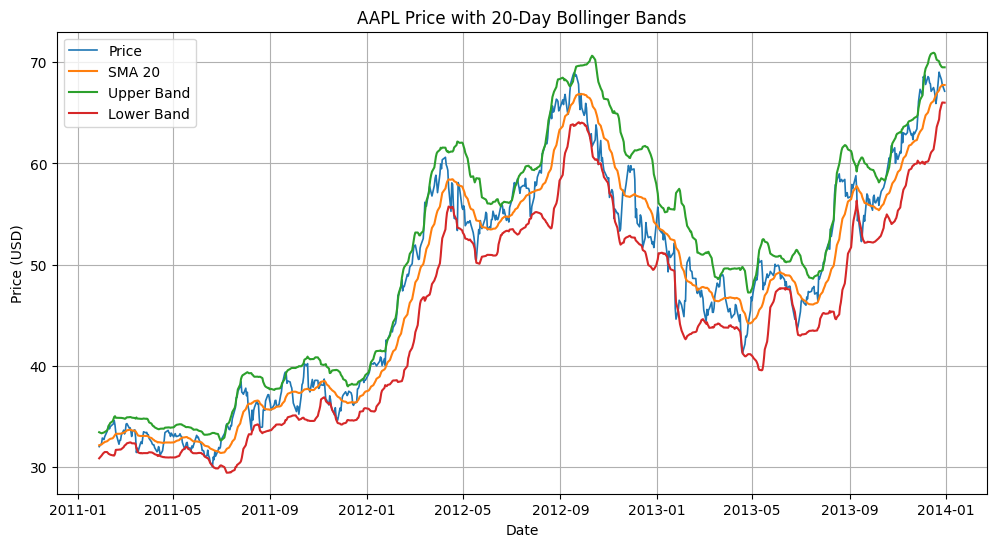

In [ ]:
# visualize price and Bollinger Bands

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[price_col], label="Price", linewidth=1.2)
plt.plot(df.index, df["SMA20"], label="SMA 20")
plt.plot(df.index, df["BB_upper"], label="Upper Band")
plt.plot(df.index, df["BB_lower"], label="Lower Band")
plt.title("AAPL Price with 20-Day Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()



# Methodology

The primary objective of this project is to compare a traditional Bollinger Bands trading strategy with ML based approaches that use technical indicators to forecast next-day returns. This section describes the construction of the technical features, the baseline strategy, the ML setup, and the justification for model selection.


## 4.1 Technical Indicators

The technical indicators used in this study each capture different dimensions of market behavior and together provide a comprehensive representation of short-term price dynamics. **Daily returns** measure immediate price fluctuations and act as a proxy for short horizon volatility and direction. **Bollinger Bands**, which combine moving averages with rolling volatility, help identify mean reversion opportunities by assessing how far prices deviate from recent trends. The **20 day rolling standard deviation (STD20)** quantifies recent volatility directly, while the **20 day simple moving average (SMA20)** smooths noise and reflects medium term trend direction. Finally, the **14 day Relative Strength Index (RSI)** captures momentum by comparing average gains and losses, highlighting potential overbought or oversold conditions.

Taken together, these indicators encode **trend, volatility, and momentum**—three foundational components of technical analysis and serve as the feature set for the ML models.


## 4.2 Baseline Bollinger Bands Strategy

The baseline benchmark is a simple Bollinger Bands trading rule:

- Enter a long position *(signal = 1)* when the closing price falls below the lower Bollinger Band.  
- Otherwise, remain in cash *(signal = 0)*.  
- To avoid look-ahead bias, the position on day *t* uses the trading signal generated on day *t − 1*.  

Strategy returns are computed as the product of the daily return and the lagged position. This rule provides a classical technical-analysis baseline against which machine-learning strategies can be evaluated.


## 4.3 Machine Learning Setup

From the technical indicators, I construct a feature matrix \( X \) consisting of:

- `SMA20`, `STD20`  
- `BB_upper`, `BB_lower`  
- `RSI14`  
- current daily return `ret`  

The target variable \( y \) is a binary indicator of whether the next-day return is positive. This formulation converts the forecasting task into a binary classification problem: predicting whether tomorrow’s return will be above zero.


## 4.4 Models Considered

Two classification models are evaluated:

1. **K-Nearest Neighbors (KNN)**  
   KNN is a non-parametric method that classifies observations based on proximity in the feature space. It provides a simple nonlinear benchmark and can capture local structure without imposing a global functional form. However, KNN can be sensitive to noise and scaling, especially in financial settings where features tend to be noisy.

2. **L2-Regularized Logistic Regression**  
   Logistic Regression provides a linear decision boundary and is widely used in financial prediction tasks due to its interpretability and stability. The addition of **L2 regularization** helps prevent overfitting by shrinking coefficient magnitudes, improving robustness when predictors are noisy or weakly informative.

Together, these models offer complementary perspectives KNN reflects local nonlinear behavior, while Logistic Regression provides a stable global classifier.


## 4.5 Resampling and Cross-Validation

To enhance robustness and prevent overfitting, both models are tuned using **5-fold K-fold cross-validation** through `GridSearchCV`. This procedure:

- selects the optimal number of neighbors and weighting scheme for KNN  
- selects the optimal regularization strength \( C \) for Logistic Regression  

Both models are implemented in scikit-learn pipelines with `StandardScaler`, ensuring that scaling is consistently applied within each fold of cross-validation. This follows best practices from the course topics on classification, resampling, and regularization.


## 4.6 Model Rationale and Extensions

Logistic Regression is well suited for financial classification problems because daily stock returns are noisy and typically exhibit low signal to noise ratios. Its linear structure and regularization provide a stable and interpretable baseline. KNN, although more sensitive to noise, serves as a useful nonlinear comparator capable of capturing local deviations from linearity.

More advanced alternatives such as tree-based models, Support Vector Machines (SVMs), or ensemble methods could potentially capture richer nonlinear relationships. These models were not included due to the scope of the project but represent promising directions for future work.

In [ ]:
# Model training baseline

# baseline Bollinger strategy
signal_bb = pd.Series(0, index=df.index)
signal_bb[df[price_col] < df["BB_lower"]] = 1   # long when price below lower band

# lag signal by one day for position
position_bb = signal_bb.shift(1).fillna(0)

strategy_ret_bb = position_bb * df["ret"]
cum_ret_bb = (1 + strategy_ret_bb).cumprod()

# buy-and-hold returns
bh_ret = df["ret"]
cum_ret_bh = (1 + bh_ret).cumprod()

# feature matrix and target
feature_cols = ["SMA20", "STD20", "BB_upper", "BB_lower", "RSI14", "ret"]
X = df[feature_cols].values
y = df["y"].values
ret_series = df["ret"]

# time-based train/test split (80% train, 20% test)
n = len(df)
split_idx = int(n * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
ret_test = ret_series.iloc[split_idx:]
dates_test = ret_test.index

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 588
Test size: 147


In [ ]:
# KNN with cross-validation

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid_knn = {
    "knn__n_neighbors": [3, 4, 5, 6, 7, 8, 9, 10, 11],
    "knn__weights": ["uniform", "distance"]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_

print("Best KNN params:", grid_knn.best_params_)
print("Best KNN CV accuracy:", grid_knn.best_score_)


Best KNN params: {'knn__n_neighbors': 4, 'knn__weights': 'uniform'}
Best KNN CV accuracy: 0.5068376068376068


In [ ]:
# Logistic Regression with cross-validation

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

param_grid_lr = {
    "logreg__C": [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_lr,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_

print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best Logistic Regression CV accuracy:", grid_lr.best_score_)


Best Logistic Regression params: {'logreg__C': 0.1}
Best Logistic Regression CV accuracy: 0.5103578154425612


# Model Training  

To evaluate out-of-sample performance, I split the time series chronologically:

- The first 80% of observations form the **data set**.  
- The final 20% of observations **data set**.

On the training set, I:

1. Fit the KNN and Logistic Regression pipelines with standardized features.  
2. Use 5-fold K-fold cross-validation with `GridSearchCV` to select hyperparameters.  
3. Choose the model specifications that maximize cross-validated accuracy.  

The resulting best models are then evaluated on the held-out test set in terms of both classification accuracy and trading performance.


In [ ]:
# Results of classification metrics

# KNN predictions
y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print("***KNN test performance:***")
print("Accuracy:", acc_knn)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification report:\n", classification_report(y_test, y_pred_knn))
print()
print()

# Logistic Regression predictions
y_pred_lr = best_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

print("***Logistic Regression test performance:***")
print("Accuracy:", acc_lr)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification report:\n", classification_report(y_test, y_pred_lr))


***KNN test performance:***
Accuracy: 0.4421768707482993
Confusion matrix:
 [[42 27]
 [55 23]]

Classification report:
               precision    recall  f1-score   support

           0       0.43      0.61      0.51        69
           1       0.46      0.29      0.36        78

    accuracy                           0.44       147
   macro avg       0.45      0.45      0.43       147
weighted avg       0.45      0.44      0.43       147



***Logistic Regression test performance:***
Accuracy: 0.5374149659863946
Confusion matrix:
 [[48 21]
 [47 31]]

Classification report:
               precision    recall  f1-score   support

           0       0.51      0.70      0.59        69
           1       0.60      0.40      0.48        78

    accuracy                           0.54       147
   macro avg       0.55      0.55      0.53       147
weighted avg       0.55      0.54      0.53       147



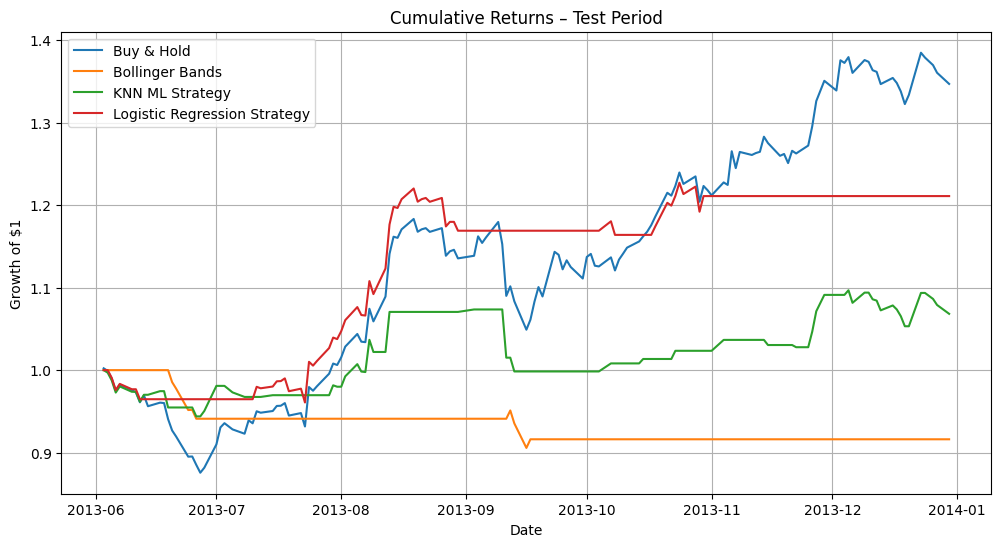

In [ ]:
# trading strategies

# align test returns
ret_test = ret_series.iloc[split_idx:]
dates_test = ret_test.index

# KNN strategy: long if model predicts y=1
signal_knn = pd.Series(y_pred_knn, index=dates_test)
position_knn = signal_knn.shift(1).fillna(0)
strategy_ret_knn = position_knn * ret_test
cum_ret_knn = (1 + strategy_ret_knn).cumprod()

# Logistic Regression strategy
signal_lr = pd.Series(y_pred_lr, index=dates_test)
position_lr = signal_lr.shift(1).fillna(0)
strategy_ret_lr = position_lr * ret_test
cum_ret_lr = (1 + strategy_ret_lr).cumprod()

# restrict baseline strategies to test period
cum_ret_bh_test = (1 + ret_test).cumprod()
cum_ret_bb_test = (1 + strategy_ret_bb.loc[dates_test]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_ret_bh_test, label="Buy & Hold")
plt.plot(cum_ret_bb_test, label="Bollinger Bands")
plt.plot(cum_ret_knn, label="KNN ML Strategy")
plt.plot(cum_ret_lr, label="Logistic Regression Strategy")
plt.title("Cumulative Returns – Test Period")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# final stat results

def summarize_strategy(returns, name="Strategy"):
    avg_daily = returns.mean()
    std_daily = returns.std()
    sharpe_like = avg_daily / std_daily if std_daily != 0 else np.nan
    total_return = (1 + returns).prod() - 1
    print(f"{name}:")
    print("Total return: {0:.2%}".format(total_return))
    print("Average daily return: {0:.4%}".format(avg_daily))
    print("Daily std: {0:.4%}".format(std_daily))
    print("Sharpe-like ratio (mean/std): {0:.2f}".format(sharpe_like))
    print()
    print()

print("Test period:", dates_test.min().date(), "to", dates_test.max().date(), "\n")

summarize_strategy(ret_test, "Buy and hold (test)")
summarize_strategy(strategy_ret_bb.loc[dates_test], "Bollinger strategy (test)")
summarize_strategy(strategy_ret_knn, "KNN (test)")
summarize_strategy(strategy_ret_lr, "Logistic Regression (test)")


Test period: 2013-06-03 to 2013-12-30 

Buy and hold (test):
Total return: 34.71%
Average daily return: 0.2147%
Daily std: 1.5468%
Sharpe-like ratio (mean/std): 0.14


Bollinger strategy (test):
Total return: -8.39%
Average daily return: -0.0587%
Daily std: 0.4208%
Sharpe-like ratio (mean/std): -0.14


KNN (test):
Total return: 6.83%
Average daily return: 0.0498%
Daily std: 0.9899%
Sharpe-like ratio (mean/std): 0.05


Logistic Regression (test):
Total return: 21.11%
Average daily return: 0.1349%
Daily std: 0.9637%
Sharpe-like ratio (mean/std): 0.14




In [ ]:
# performance summary table
def safe_sharpe(avg, std):
    return avg / std if std not in [0, np.nan] else np.nan

performance_data = []

strategies = {
    "Buy & Hold": ret_test,
    "Bollinger Bands": strategy_ret_bb.loc[dates_test],
    "KNN Strategy": strategy_ret_knn,
    "Logistic Regression": strategy_ret_lr,
}

for name, series in strategies.items():
    total_ret = (1 + series).prod() - 1
    avg = series.mean()
    std = series.std()
    sharpe = safe_sharpe(avg, std)

    performance_data.append([
        name,
        total_ret,
        avg,
        std,
        sharpe
    ])

performance_df = pd.DataFrame(
    performance_data,
    columns=["Strategy", "Total Return", "Avg Daily Return", "Daily Volatility", "Sharpe-like Ratio"]
)

# Format table for readability
performance_df_style = performance_df.style.format({
    "Total Return": "{:.2%}",
    "Avg Daily Return": "{:.4%}",
    "Daily Volatility": "{:.4%}",
    "Sharpe-like Ratio": "{:.3f}"
})

performance_df_style


,Strategy,Total Return,Avg Daily Return,Daily Volatility,Sharpe-like Ratio
0,Buy & Hold,34.71%,0.2147%,1.5468%,0.139
1,Bollinger Bands,-8.39%,-0.0587%,0.4208%,-0.139
2,KNN Strategy,6.83%,0.0498%,0.9899%,0.050
3,Logistic Regression,21.11%,0.1349%,0.9637%,0.140


# Results and Evaluation  

## 5.1 Classification performance  

On the test set (147 observations), the KNN classifier achieves an accuracy of about **44.2%**, which is below a 50% random baseline. The confusion matrix and classification report indicate that KNN struggles to correctly identify both positive and negative return days, which is consistent with the fact that daily stock returns are very noisy and KNN is sensitive to such noise.

The L2-regularized Logistic Regression model performs noticeably better, with a test accuracy of about **53.7%**. Although this improvement over 50% may look small in absolute terms, it is typical and meaningful in the context of daily equity return prediction. The confusion matrix shows that Logistic Regression achieves higher recall for down days and more balanced precision and recall across the two classes compared with KNN. These results suggest that a simple linear decision boundary with regularization is better suited to this dataset than KNN.

## 5.2 Trading performance  

I then translate the model predictions into simple long or cash trading strategies and compare them with buy-and-hold and the Bollinger Bands rule over the test period (2013-06-03 to 2013-12-30). The summary statistics are:

- **Buy-and-hold (test):**  
  - Total return: **34.71%**  
  - Sharpe-like ratio (mean/std): **0.14**

- **Bollinger Bands strategy (test):**  
  - Total return: **-8.39%**  
  - Sharpe-like ratio: **-0.14**

- **KNN strategy (test):**  
  - Total return: **6.83%**  
  - Sharpe-like ratio: **0.05**

- **Logistic Regression strategy (test):**  
  - Total return: **21.11%**  
  - Sharpe-like ratio: **0.14**

The results show that the Bollinger only strategy performs poorly in this sample, generating a negative total return and the worst risk adjusted performance. The KNN-based strategy improves on Bollinger Bands but still lags behind the other approaches. The Logistic Regression strategy performs substantially better than both Bollinger Bands and KNN, with a positive total return and a Sharpe like ratio comparable to buy-and-hold. However, it does not outperform buy-and-hold on total return in this test period, which highlights how difficult it is to beat a simple passive strategy over a relatively short horizon.


# Conclusion  

This project integrated technical analysis, classification methods, resampling techniques, and regularization to examine whether machine learning can enhance a traditional Bollinger Bands trading strategy for Apple Inc. (AAPL). Using daily price data from 2010-12-31 to 2013-12-31, a set of widely used technical indicators was constructed and the forecasting task was formulated as a binary classification problem that predicts next-day return direction.

Empirical results indicate that the K-Nearest Neighbors (KNN) model performs poorly out of sample, reflecting its sensitivity to noise and local variability in financial time-series data. In contrast, the L2-regularized LR model achieves a modest but meaningful improvement over a random 50% baseline in directional prediction accuracy. When translated into trading strategies, the LR based approach clearly outperforms both the KNN-based strategy and the pure Bollinger Bands strategy in terms of total return and risk adjusted performance. However, it does not surpass the buy-and-hold benchmark over the same period, underscoring the difficulty of consistently outperforming passive investment strategies.

Overall, these findings highlight both the potential and the limitations of applying machine learning to short horizon equity return prediction. While machine learning can improve upon rigid technical rules, the low signal to noise ratio in daily stock returns imposes fundamental constraints on predictive accuracy. Consequently, careful model selection, regularization, and evaluation are essential when applying machine learning techniques in financial contexts.

# Limitations and Future Work  

Several limitations of this analysis should be acknowledged. First, **transaction costs are ignored**, which would likely reduce the profitability of ML based strategies due to more frequent trading. Second, the study focuses on a **single asset (AAPL)**, and the results may not generalize across different sectors, market regimes, or asset classes. Third, the trading framework is restricted to **long or cash positions**, excluding short selling and leverage, which may limit potential returns.

In addition, **walk forward validation or rolling window retraining** is not implemented, meaning the models do not adapt dynamically to structural changes in the market. Finally, the technical indicators rely on **fixed window lengths** for example, 14 day RSI and 20 day moving averages, which may not be optimal for all market conditions. Addressing these limitations in future work by incorporating transaction costs, expanding to multiple assets, adopting adaptive validation schemes, and exploring alternative models such as tree-based methods or Support Vector Machines, would provide a more comprehensive assessment of the robustness and generalizability of ML based trading strategies.
